In [ ]:
# 패키지 설치
!pip install yfinance --quiet

In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
sns.set()

## 데이터셋 준비

총 16개 ETF에 대한 가격 데이터를 다운받아오도록 하겠습니다. 여기서 사용하게 될 데이터는 전부 주간 단위 데이터입니다. 

In [2]:
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('W').last()

[*********************100%***********************]  9 of 9 completed


In [3]:
data

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2010-01-10,25.910635,38.420540,9.638060,22.417383,18.880983,18.392271,18.949060,25.142193,25.458538
2010-01-17,25.079596,37.757885,9.460747,22.279432,18.569586,18.530718,19.066257,25.490295,25.115067
2010-01-24,23.469456,35.871902,8.979479,21.336746,17.750092,18.198448,18.393908,25.047253,24.310850
2010-01-31,22.363878,34.725040,8.979479,20.984200,17.176447,18.136147,18.215031,24.746622,24.218702
2010-02-07,22.616159,34.559372,8.827498,20.846247,17.266592,17.983860,17.838760,24.390612,24.101421
...,...,...,...,...,...,...,...,...,...
2023-10-15,77.639999,89.589996,33.209999,101.750000,168.630005,66.800003,59.299999,130.190002,158.970001
2023-10-22,75.300003,90.260002,32.200001,98.699997,163.940002,67.269997,58.029999,128.059998,151.690002
2023-10-29,74.949997,84.629997,31.450001,96.440002,161.119995,66.580002,58.730000,123.139999,149.589996


In [4]:
# 수익률
rets = data.pct_change().fillna(0)

In [5]:
# 색깔 팔레트
pal = sns.color_palette('Spectral', len(tickers))

### 동일 비중 포트폴리오

<Axes: xlabel='Date'>

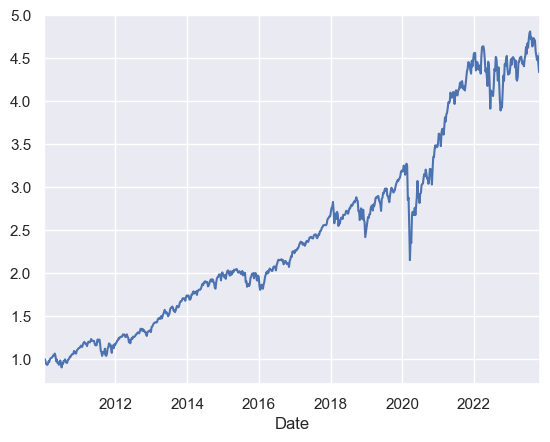

In [6]:
# 동일 비중 포트폴리오 수익률
port_rets = rets.mean(axis=1)

# 백테스팅 결과
(1 + port_rets).cumprod().plot()

### 변동성 타겟팅 모델

<Axes: xlabel='Date'>

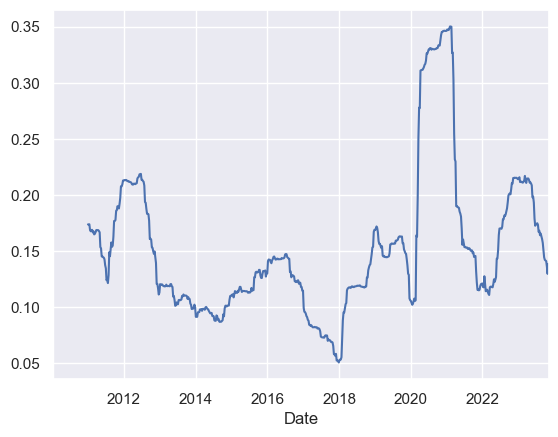

In [7]:
# 1년 롤링 변동성 계산
rolling_vol = port_rets.rolling(52).std() * np.sqrt(52)
rolling_vol.plot()

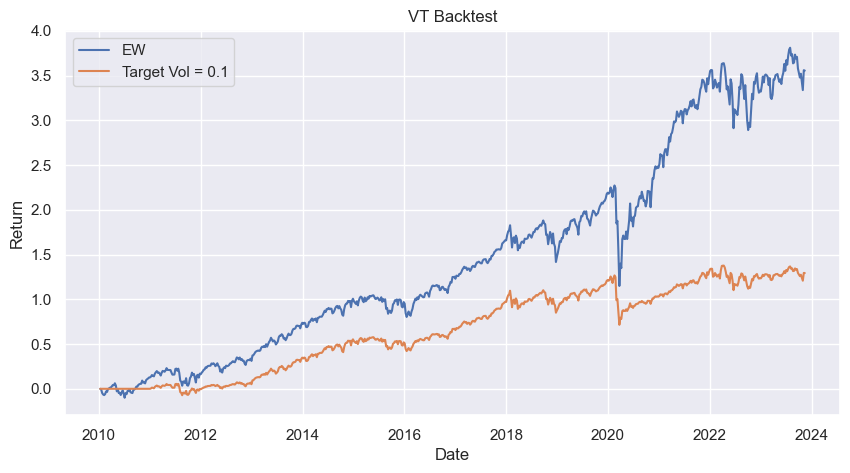

In [13]:
# 변동성 타겟팅을 사용해 투자 가중치 산출
# 타겟 변동성 = 10%
target_vol = 0.1
vt_weights = (target_vol / rolling_vol).fillna(0)

# 레버리지 사용 불가
vt_weights[vt_weights > 1] = 1

# 볼타겟 백테스팅 수익률
tvol_rets = (port_rets * vt_weights.shift()).fillna(0)
tvol_cum_rets = (1 + tvol_rets).cumprod()-1

# 백테스팅 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot((1 + port_rets).cumprod()-1, label='EW')
plt.plot(tvol_cum_rets, label=f'Target Vol = {target_vol}')
plt.title('VT Backtest')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()

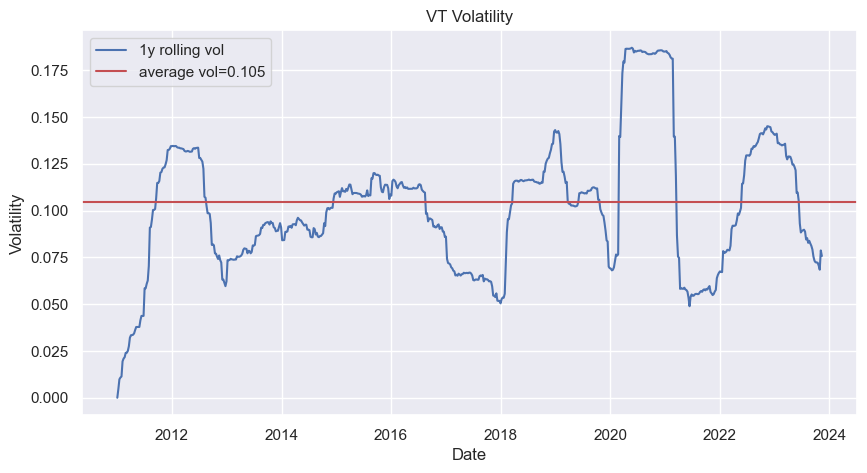

In [14]:
# 변동성 타겟팅 포트폴리오의 시계열 변동성 시각화
plt.figure(figsize=(10, 5))
plt.plot((tvol_rets.rolling(52).std() * np.sqrt(52)).dropna(), label='1y rolling vol')
plt.axhline((tvol_rets.std() * np.sqrt(52)).mean(), color='r', label=f'average vol={np.round((tvol_rets.std() * np.sqrt(52)).mean(), 3)}')
plt.title('VT Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [10]:
# 현금 보유 비중
1 - vt_weights

Date
2010-01-10    1.000000
2010-01-17    1.000000
2010-01-24    1.000000
2010-01-31    1.000000
2010-02-07    1.000000
                ...   
2023-10-15    0.291255
2023-10-22    0.266404
2023-10-29    0.229548
2023-11-05    0.278102
2023-11-12    0.236657
Freq: W-SUN, Length: 723, dtype: float64

In [11]:
# 투자 비중 데이터프레임 생성
vt_weights_df = pd.concat([vt_weights, 1-vt_weights], axis=1, join='inner')
vt_weights_df.columns = ['portfolio', 'cash']
vt_weights_df

,portfolio,cash
Date,,
2010-01-10,0.000000,1.000000
2010-01-17,0.000000,1.000000
2010-01-24,0.000000,1.000000
2010-01-31,0.000000,1.000000
2010-02-07,0.000000,1.000000
...,...,...
2023-10-15,0.708745,0.291255
2023-10-22,0.733596,0.266404
2023-10-29,0.770452,0.229548


Text(0, 0.5, 'Weights')

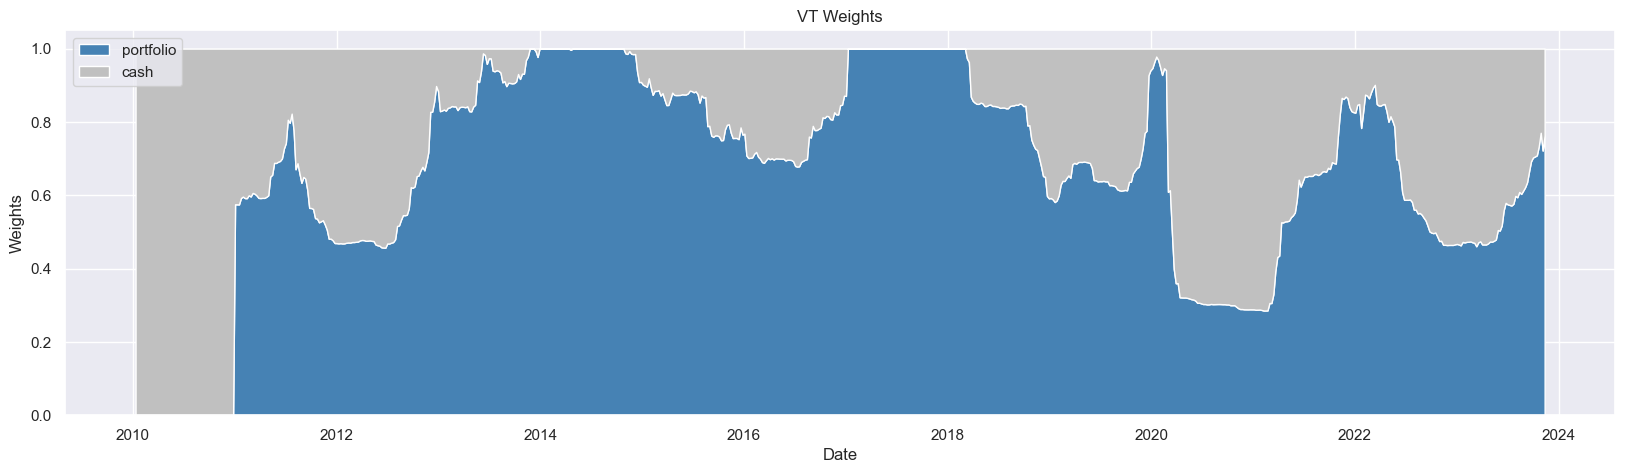

In [12]:
# 시계열 플랏 시각화
plt.figure(figsize=(20, 5))
plt.stackplot(vt_weights_df.index, vt_weights_df.T, labels=vt_weights_df.columns, colors=['steelblue', 'silver'])
plt.legend(loc='upper left')
plt.title('VT Weights')
plt.xlabel('Date')
plt.ylabel('Weights')

Copyright 2022. 퀀트대디. All rights reserved.